# Introduction

CausalML is a Python package that provides a suite of uplift modeling and causal inference methods using machine learning algorithms based on recent research. The package currently supports the following methods:

Tree-based algorithms
* Uplift tree/random forests on KL divergence, Euclidean Distance, and Chi-Square
* Uplift tree/random forests on Contextual Treatment Selection

Meta-learner algorithms
* S-learner
* T-learner
* X-learner
* R-learner

In this notebook, we use synthetic data to demonstrate the use of the tree-based algorithms.

In [1]:
import numpy as np
import pandas as pd

from causalml.dataset import make_uplift_classification
from causalml.inference.tree import UpliftRandomForestClassifier
from causalml.metrics import plot_gain

from sklearn.model_selection import train_test_split

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
Failed to import duecredit due to No module named 'duecredit'


In [2]:
import importlib
print(importlib.metadata.version('causalml') )

0.14.0


# Generate synthetic dataset

The CausalML package contains various functions to generate synthetic datasets for uplift modeling. Here we generate a classification dataset using the make_uplift_classification() function.

In [3]:
df, x_names = make_uplift_classification()

In [4]:
df.head()

,treatment_group_key,x1_informative,x2_informative,x3_informative,x4_informative,x5_informative,x6_irrelevant,x7_irrelevant,x8_irrelevant,x9_irrelevant,...,x12_uplift_increase,x13_increase_mix,x14_uplift_increase,x15_uplift_increase,x16_increase_mix,x17_uplift_increase,x18_uplift_increase,x19_increase_mix,conversion,treatment_effect
0,control,-0.542888,1.976361,-0.531359,-2.354211,-0.380629,-2.614321,-0.128893,0.448689,-2.275192,...,-1.315304,0.742654,1.891699,-2.428395,1.541875,-0.817705,-0.610194,-0.591581,0,0
1,treatment3,0.258654,0.552412,1.434239,-1.422311,0.089131,0.790293,1.159513,1.578868,0.166540,...,-1.391878,-0.623243,2.443972,-2.889253,2.018585,-1.109296,-0.380362,-1.667606,0,0
2,treatment1,1.697012,-2.762600,-0.662874,-1.682340,1.217443,0.837982,1.042981,0.177398,-0.112409,...,-1.132497,1.050179,1.573054,-1.788427,1.341609,-0.749227,-2.091521,-0.471386,0,0
3,treatment2,-1.441644,1.823648,0.789423,-0.295398,0.718509,-0.492993,0.947824,-1.307887,0.123340,...,-2.084619,0.058481,1.369439,0.422538,1.087176,-0.966666,-1.785592,-1.268379,1,1
4,control,-0.625074,3.002388,-0.096288,1.938235,3.392424,-0.465860,-0.919897,-1.072592,-1.331181,...,-1.403984,0.760430,1.917635,-2.347675,1.560946,-0.833067,-1.407884,-0.781343,0,0


In [5]:
# Look at the conversion rate and sample size in each group
df.pivot_table(values='conversion',
               index='treatment_group_key',
               aggfunc=[np.mean, np.size],
               margins=True)

,mean,size
,conversion,conversion
treatment_group_key,,
control,0.511,1000
treatment1,0.514,1000
treatment2,0.559,1000
treatment3,0.600,1000
All,0.546,4000


# Run the uplift random forest classifier

In this section, we first fit the uplift random forest classifier using training data. We then use the fitted model to make a prediction using testing data. The prediction returns an ndarray in which each column contains the predicted uplift if the unit was in the corresponding treatment group.

In [6]:
# Split data to training and testing samples for model validation (next section)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=111)

In [7]:
from causalml.inference.tree import UpliftTreeClassifier

In [8]:
clf = UpliftTreeClassifier(control_name='control')
clf.fit(df_train[x_names].values,
         treatment=df_train['treatment_group_key'].values,
         y=df_train['conversion'].values)
p = clf.predict(df_test[x_names].values)

In [9]:
df_res = pd.DataFrame(p, columns=clf.classes_)
df_res.head()

,control,treatment1,treatment2,treatment3
0,0.506394,0.511811,0.573935,0.503778
1,0.506394,0.511811,0.573935,0.503778
2,0.580838,0.458824,0.508982,0.452381
3,0.482558,0.572327,0.556757,0.961538
4,0.482558,0.572327,0.556757,0.961538


In [10]:
uplift_model = UpliftRandomForestClassifier(control_name='control')

In [11]:
uplift_model.fit(df_train[x_names].values,
                 treatment=df_train['treatment_group_key'].values,
                 y=df_train['conversion'].values)

In [12]:
df_res = uplift_model.predict(df_test[x_names].values, full_output=True)
print(df_res.shape)
df_res.head()

(800, 9)


,control,treatment1,treatment2,treatment3,recommended_treatment,delta_treatment1,delta_treatment2,delta_treatment3,max_delta
0,0.465040,0.486539,0.478824,0.505152,3,0.021499,0.013784,0.040111,0.040111
1,0.444785,0.452068,0.529353,0.493128,2,0.007283,0.084568,0.048343,0.084568
2,0.518872,0.576617,0.577938,0.573603,2,0.057745,0.059066,0.054731,0.059066
3,0.425488,0.464641,0.442554,0.867118,3,0.039153,0.017067,0.441630,0.441630
4,0.520411,0.565095,0.592740,0.790936,3,0.044685,0.072329,0.270526,0.270526


In [13]:
y_pred = uplift_model.predict(df_test[x_names].values)

In [14]:
y_pred.shape

(800, 3)

In [15]:
# Put the predictions to a DataFrame for a neater presentation
# The output of `predict()` is a numpy array with the shape of [n_sample, n_treatment] excluding the
# predictions for the control group.
result = pd.DataFrame(y_pred,
                      columns=uplift_model.classes_[1:])
result.head()

,treatment1,treatment2,treatment3
0,0.021499,0.013784,0.040111
1,0.007283,0.084568,0.048343
2,0.057745,0.059066,0.054731
3,0.039153,0.017067,0.441630
4,0.044685,0.072329,0.270526


# Create the uplift curve

The performance of the model can be evaluated with the help of the [uplift curve](http://proceedings.mlr.press/v67/gutierrez17a/gutierrez17a.pdf). 

## Create a synthetic population

The uplift curve is calculated on a synthetic population that consists of those that were in the control group and those who happened to be in the treatment group recommended by the model. We use the synthetic population to calculate the _actual_ treatment effect within _predicted_ treatment effect quantiles. Because the data is randomized, we have a roughly equal number of treatment and control observations in the predicted quantiles and there is no self selection to treatment groups.

In [16]:
# If all deltas are negative, assing to control; otherwise assign to the treatment
# with the highest delta
best_treatment = np.where((result < 0).all(axis=1),
                           'control',
                           result.idxmax(axis=1))

# Create indicator variables for whether a unit happened to have the
# recommended treatment or was in the control group
actual_is_best = np.where(df_test['treatment_group_key'] == best_treatment, 1, 0)
actual_is_control = np.where(df_test['treatment_group_key'] == 'control', 1, 0)

In [17]:
synthetic = (actual_is_best == 1) | (actual_is_control == 1)
synth = result[synthetic]

## Calculate the observed treatment effect per predicted treatment effect quantile

We use the observed treatment effect to calculate the uplift curve, which answers the question: how much of the total cumulative uplift could we have captured by targeting a subset of the population sorted according to the predicted uplift, from highest to lowest?

CausalML has the plot_gain() function which calculates the uplift curve given a DataFrame containing the treatment assignment, observed outcome and the predicted treatment effect.

In [18]:
auuc_metrics = (synth.assign(is_treated = 1 - actual_is_control[synthetic],
                             conversion = df_test.loc[synthetic, 'conversion'].values,
                             uplift_tree = synth.max(axis=1))
                     .drop(columns=list(uplift_model.classes_[1:])))

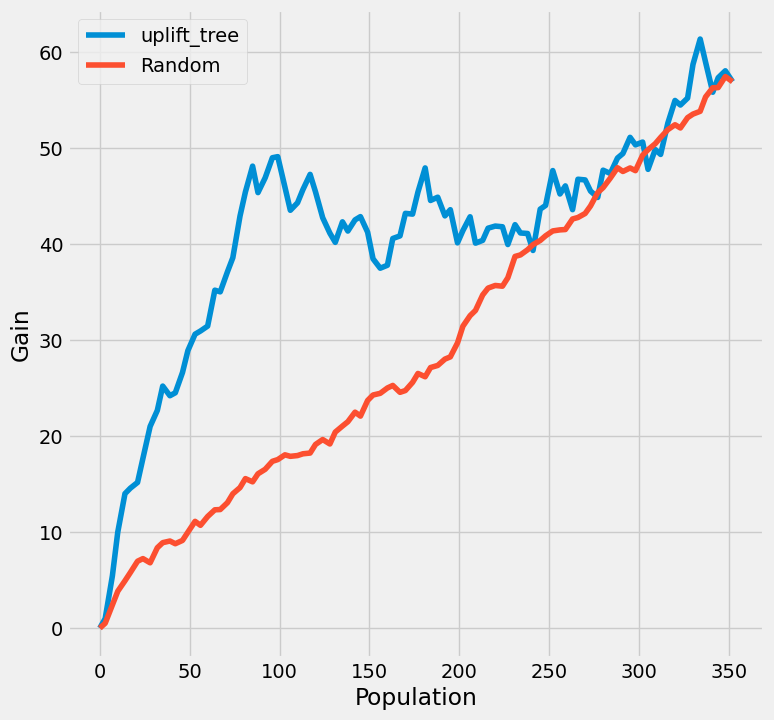

In [19]:
plot_gain(auuc_metrics, outcome_col='conversion', treatment_col='is_treated')